In [1]:
import nibabel as nib
from dipy.io import read_bvals_bvecs
import os, shutil
import FSLWrapper as fsl
import Preprocessing as preprocessing
import Processing as processing
import Utils as ut
import Definitions as definitions
import ProcessData as p
import Utils as utils
from dipy.core.geometry import vector_norm
import numpy as np

/home/cristian/.virtualenvs/tk/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/cristian/.virtualenvs/tk/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
pathIn="/home/cristian/Escritorio/Tratografia/data/In/"
pathOut="/home/cristian/Escritorio/Tratografia/data/Out2/"
lstDir=os.walk(pathIn)

In [3]:
## Identifica los Archivos

fdwiName1 = ""
fdwiName2 = ""
ext1 = ""
ext2 = ""

for root, dirs, files in lstDir:
    for fichero in files:
        (nombreFichero, extension) = os.path.splitext(fichero)
        if((extension == ".nii") or (extension == ".gz")):

            if ((fdwiName1 == "")):
                ext1 = extension
                fdwiName1 = nombreFichero
            elif (fdwiName2 == ""):
                fdwiName2 = nombreFichero
                ext2 = extension
        if(extension == ".bvec"):
            fbvec = pathIn + nombreFichero + extension
            refName = nombreFichero
        if(extension == ".bval"):
            fbval = pathIn + nombreFichero + extension
            refName = nombreFichero
            

if (refName != fdwiName1):
    fdwiT1 = pathIn + fdwiName1 + ext1
    fdwi   = pathIn + fdwiName2 + ext2
else:
    fdwiT1 = pathIn + fdwiName2 + ext2
    fdwi   = pathIn + fdwiName1 + ext1

print('Se procesaran los siguientes arhivos: ')
print(fdwi)
print(fdwiT1)
print(fbval)
print(fbvec)

Se procesaran los siguientes arhivos: 
/home/cristian/Escritorio/Tratografia/data/In/DWI.nii.gz
/home/cristian/Escritorio/Tratografia/data/In/T1.nii.gz
/home/cristian/Escritorio/Tratografia/data/In/DWI.bval
/home/cristian/Escritorio/Tratografia/data/In/DWI.bvec


In [4]:
img=nib.load(fdwi) ## Carga imagen dwi
data = img.get_data() ## matriz 4D 256,256,63,31
affine= img.affine #An affine array that tells you the position of the image array data in a reference space.
bvals, bvecs = read_bvals_bvecs(fbval, fbvec) ## trasnforma a arreglos np
dwi_mask = bvals > 0 ## array bool 
bvecs = np.where(np.isnan(bvecs), 0, bvecs)## convierte nan en 0
bvecs_close_to_1 = abs(vector_norm(bvecs) - 1) <= 0.1 ## valida cuales vectores no tienen norma cercana a 1
bvecs_close_to_1[0] = True ## la norma del primero es cero, se asigna True
bvals = bvals[bvecs_close_to_1]## toma solo los valores y vectores con norma cercana a 1 y el 0
bvecs = bvecs[bvecs_close_to_1]
data = data[..., bvecs_close_to_1]

## si no todos son True al final actualiza la informacion
if not np.all(bvecs_close_to_1) == True: 
    np.savetxt(fbval, bvals, delimiter='    ', fmt='%s')
    np.savetxt(fbvec, bvecs, delimiter='    ', fmt='%s')
    nib.save(nib.Nifti1Image(data, affine), fdwi)
## si existe carpeta temporal la elimina
if os.path.exists(definitions.Definitions.tempPath):
    shutil.rmtree(definitions.Definitions.tempPath)#Elimina carpeta y su contenido
    #ut.delete_Files(definitions.Definitions.tempPath)
    #os.removedirs(definitions.Definitions.tempPath)
os.mkdir(definitions.Definitions.tempPath)

## si hay img estructural 
if (fdwiName2 != ""):
    ## Extraccion cerebro
    print('-> Preprocesado image estructural')
    fsl.BET(fdwiT1, pathOut +'Structural_BET.nii', '-f .25')
    #Transformacion T1 a MNI
    if not(os.path.exists(pathOut + 'Structural_Normalized.nii')):
       warped_Structural, MNI_T2_affine, mapping_Structural = p.registrationtoNMI(pathOut + 'Structural_BET.nii.gz', pathOut)
       nib.save(nib.Nifti1Image(warped_Structural.astype(np.float32), MNI_T2_affine), pathOut + 'Structural_Normalized.nii')

-> Preprocesado image estructural


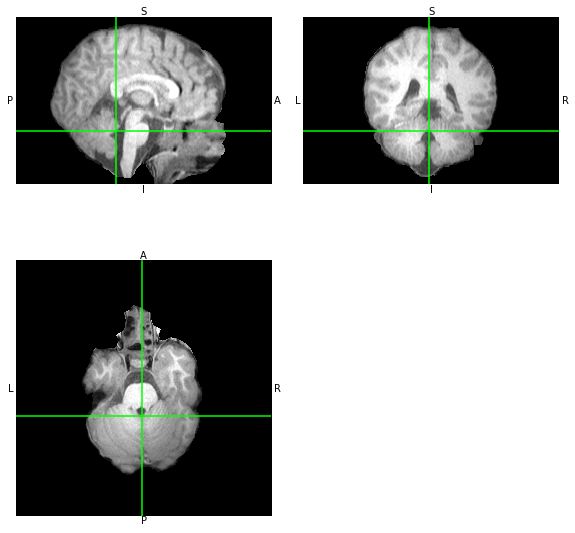

(0.9766, 0.9766, 1.0)


In [6]:
img = nib.load(pathOut+'Structural_BET.nii.gz')
data_s=img.get_data()
a_s=img.affine
p=nib.viewers.OrthoSlicer3D(data_s,affine=a_s)
p.set_position(0,0,0) #(-122-127,1-256,-52-111)
p.show()
print(img.header.get_zooms())

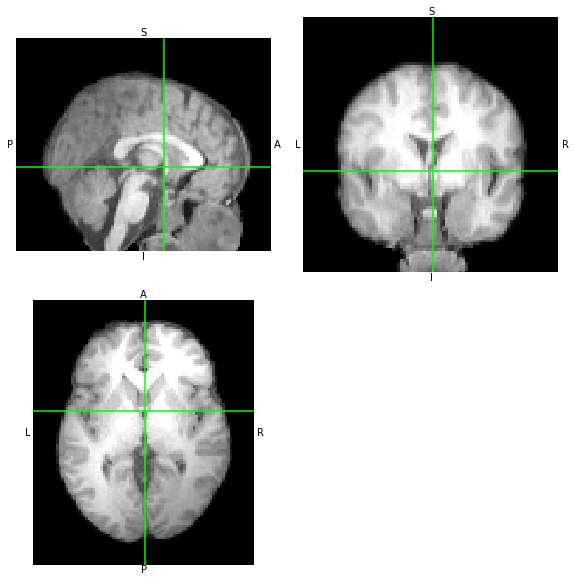

(2.0, 2.0, 2.0)


In [7]:
imgN = nib.load(pathOut+'Structural_Normalized.nii')
dataN=imgN.get_data()
aN=imgN.affine
p=nib.viewers.OrthoSlicer3D(dataN,affine=aN)
p.set_position(0,0,0) #(-122-127,1-256,-52-111)
p.show()
print(imgN.header.get_zooms())

In [8]:
## DWI preprocessing

## RESlice
from dipy.align.reslice import reslice
def Reslice_DWI (file_in, outPath, vox_sz):

    print('Reslice...')

    refNameOnly = utils.extractFileName(file_in)#nombre archivo
    if not(os.path.exists(outPath + utils.extractFileName(file_in) + definitions.Definitions.idReslice + definitions.Definitions.extension)):
    #if (1):

       img = nib.load(file_in)
       data = img.get_data()
       affine = img.affine

       old_vox_sz = img.header.get_zooms()[:3]## tamaño original voxeles en milimetros

       new_vox_sz = (vox_sz, vox_sz, vox_sz)## tamaño a transformar isotropico

       #Si el tamano del voxel es isotropico, no es necesario hacer el reslice
       data, affine = reslice(data, affine, old_vox_sz, new_vox_sz)
       nib.save(nib.Nifti1Image(data, affine), outPath + refNameOnly + definitions.Definitions.idReslice + definitions.Definitions.extension)

       #img = nib.load(outPath + refNameOnly + definitions.Definitions.idReslice + definitions.Definitions.extension)
       #vox_sz = img.get_header().get_zooms()[:3]
       #a = 1
    return outPath + refNameOnly + definitions.Definitions.idReslice + definitions.Definitions.extension

file_in=fdwi
outPath=pathOut
vox_sz=definitions.Definitions.vox_sz
Reslice_DWI(file_in,outPath,vox_sz)

Reslice...


'/home/cristian/Escritorio/Tratografia/data/Out2/DWI_Reslice.nii.gz'

In [9]:
## EddyCorrect
#correccion corrientes de eddy
def EddyCorrect_DWI (file_in, outPath, ref_bo):
    """
    Prueba documental.

    In:

    file_in: akakakakka
    outPath: kakakasjdjdlllf kklkd
    ref_bo. kskskdejien skkd  dllkd

    Out:

    """
    print('Eddy Correction...')
    refNameOnly = utils.extractFileName(file_in)

    if not(os.path.exists(outPath + utils.extractFileName(file_in) + definitions.Definitions.idEddyCorrect + definitions.Definitions.extension)):
       refName = utils.extractFileNameExt(file_in)

       os.system('cp ' + file_in + ' ' + definitions.Definitions.tempPath) #Copiamos archivo de difusion a la carpeta temporal
       fsl.EDDYCORRECT(definitions.Definitions.tempPath + refName, definitions.Definitions.tempPath + refNameOnly + definitions.Definitions.idEddyCorrect + '.nii', ref_bo)
       os.system('cp ' + definitions.Definitions.tempPath + refNameOnly + definitions.Definitions.idEddyCorrect + definitions.Definitions.extension + ' ' + outPath) #Copiamos archivo de difusion desde carpeta temporal

    return outPath + refNameOnly + definitions.Definitions.idEddyCorrect + definitions.Definitions.extension

file_in=Reslice_DWI(file_in,outPath,vox_sz)
ref_b0="0"
EddyCorrect_DWI(file_in,outPath,ref_b0)

Reslice...
Eddy Correction...


'/home/cristian/Escritorio/Tratografia/data/Out2/DWI_Reslice_EddyCorrect.nii.gz'

Eddy Correction...


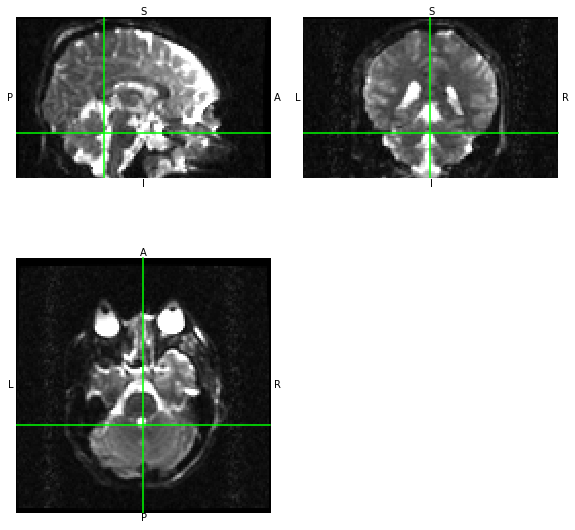

(2.0, 2.0, 2.0)


In [10]:
## b0
file_in=EddyCorrect_DWI(file_in,outPath,ref_b0)
img = nib.load(file_in)
data = img.get_data()
aN=img.affine
mask = data[..., 0] 
p=nib.viewers.OrthoSlicer3D(mask,affine=aN)
p.set_position(0,0,0) #(-122-127,1-256,-52-111)
p.show()
print(imgN.header.get_zooms())

In [ ]:
#NonLocalMean_DWI
def NonLocalMean_DWI (file_in, outPath, threshold, ref_b0):

    print('NonLocal Mean...')

    refNameOnly = utils.extractFileName(file_in)
    if not(os.path.exists(outPath + utils.extractFileName(file_in) + definitions.Definitions.idNonLocalMean + definitions.Definitions.extension)):

       img = nib.load(file_in)#DWI con eddy
       data = img.get_data()
       mask = data[..., ref_b0] > threshold ## En la b0 cuando sea mayor al umbral
       data2 = data[..., ref_b0]##B0
       sigma = np.std(data2[~mask])#std de la lista valores no mayores a treshold
        ##dipy denoise nlmeans
       den = nlmeans(data2, sigma=sigma, mask=mask)

       nib.save(nib.Nifti1Image(den.astype(np.float32), img.affine), outPath + refNameOnly + definitions.Definitions.idNonLocalMean + definitions.Definitions.extension)

    return outPath + refNameOnly + definitions.Definitions.idNonLocalMean + definitions.Definitions.extension
file_in=EddyCorrect_DWI(file_in,outPath,ref_b0)
treshols=definitions.Definitions.threshold
NonLocalMean_DWI (file_in, outPath, threshold, int(ref_b0)):

In [175]:
data.max()

9679

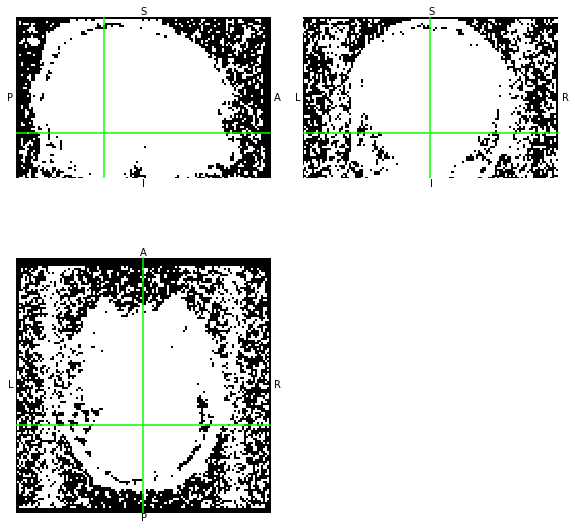

(2.0, 2.0, 2.0)


In [11]:
## b0
mask = data[..., 0] > 100
p=nib.viewers.OrthoSlicer3D(mask,affine=aN)
p.set_position(0,0,0) #(-122-127,1-256,-52-111)
p.show()
print(imgN.header.get_zooms())

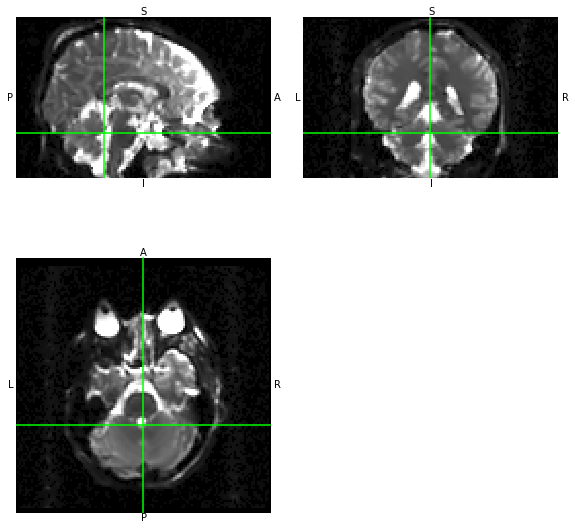

(2.0, 2.0, 2.0)


In [13]:
from dipy.denoise.nlmeans import nlmeans
data2 = data[..., 0]
sigma = np.std(data2[~mask])
sigma
den = nlmeans(data2, sigma=sigma, mask=mask)
p=nib.viewers.OrthoSlicer3D(den,affine=aN)
p.set_position(0,0,0) #(-122-127,1-256,-52-111)
p.show()
print(imgN.header.get_zooms())

In [185]:
##Median_Otsu
#Simple brain extraction tool method for images from DWI data.
#It uses a median filter smoothing of the input_volumes 
#vol_idx and an automatic histogram Otsu thresholding 
#technique, hence the name median_otsu.

#median_otsu returns the segmented brain data and
#a binary mask of the brain.

#median_radius : int

 #   Radius (in voxels) of the applied median filter (default: 4).
    
#numpass: int

 #   Number of pass of the median filter (default: 4).


def Median_Otsu_DWI (file_in, outPath, median_radius, num_pass):

    print('Median Otsu...')

    refNameOnly = utils.extractFileName(file_in)

    if not(os.path.exists(outPath + utils.extractFileName(file_in) + definitions.Definitions.idMedianOtsu + '_mask' + definitions.Definitions.extension)):

       img = nib.load(file_in)
       data = img.get_data()
       b0_mask, mask = median_otsu(data, median_radius, num_pass)

       nib.save(nib.Nifti1Image(b0_mask.astype(np.float32), img.affine), outPath + refNameOnly + definitions.Definitions.idMedianOtsu + '_b0' + definitions.Definitions.extension)
       nib.save(nib.Nifti1Image(mask.astype(np.float32), img.affine), outPath + refNameOnly + definitions.Definitions.idMedianOtsu + '_mask' + definitions.Definitions.extension)

    return outPath + refNameOnly + definitions.Definitions.idMedianOtsu + '_mask' + definitions.Definitions.extension


In [14]:
from dipy.segment.mask import median_otsu
median_radius   = 4
num_pass        = 4
b0_mask, mask = median_otsu(den, median_radius, num_pass)

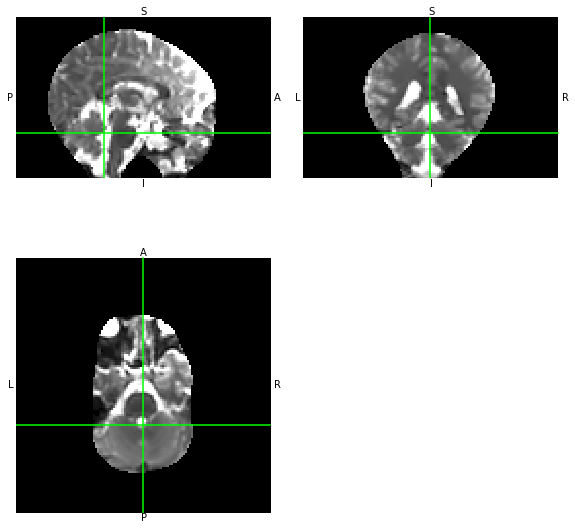

(2.0, 2.0, 2.0)


In [15]:
p=nib.viewers.OrthoSlicer3D(b0_mask,affine=aN)
p.set_position(0,0,0) #(-122-127,1-256,-52-111)
p.show()
print(imgN.header.get_zooms())

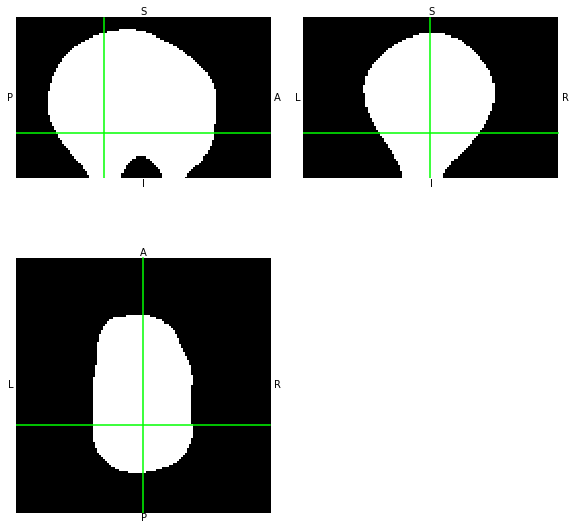

(2.0, 2.0, 2.0)


In [16]:
p=nib.viewers.OrthoSlicer3D(mask,affine=aN)
p.set_position(0,0,0) #(-122-127,1-256,-52-111)
p.show()
print(imgN.header.get_zooms())